In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.opengl)

S = 512

def matmul():
    A = tf.input([-1, -1], tf.float32)
    N, M = A.shape
    B = tf.input([M, -1], tf.float32)
    K = B.shape[1]
    
    if(False): # This does atomics - very slow
        C = tf.zeros([N, K])
        i, j, k = tf.indices([N, K, M])
        tf.scatterAdd(C[i, j], A[i, k] * Bt[j, k])
    else: # This does a loop - much faster
        i, j, k = tf.indices([N, K, M])
        C = tf.sum(A[i, k] * B[k, j])
        
    return [C]

mmul = tf.compile(matmul)

TensorFrost module loaded!
matmul:
  Kernel count: 1
  Intermediate buffers: 0
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 379
  IR Compile time: 0.424900 ms
  Compiler time: 1772.935913 ms



In [2]:
Anp = np.random.rand(64, 32).astype(np.float32)
Bnp = np.random.rand(32, 48).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)

Cerror = np.linalg.norm(Cnp - Cnp2) / np.linalg.norm(Cnp2)
print("Error:", Cerror)


[[ 6.9310784  8.706849   7.2276053 ...  7.177378   8.859088   6.310781 ]
 [ 6.9832864  9.159225   6.482232  ...  8.482692   9.651101   6.9194355]
 [ 6.7837586  8.911072   6.7696314 ...  7.341627   8.987601   7.8427644]
 ...
 [ 8.094019  10.876477   8.877196  ...  9.148143  11.647156   8.730384 ]
 [ 7.134771   7.9971857  6.095591  ...  6.9916263  8.131668   7.050233 ]
 [ 8.116204  10.309599   7.502683  ...  7.6748815  9.296843   7.953954 ]]
[[ 6.9310784  8.706849   7.227605  ...  7.177377   8.859089   6.31078  ]
 [ 6.983287   9.159225   6.482232  ...  8.482691   9.6511     6.9194355]
 [ 6.78376    8.911072   6.769631  ...  7.341627   8.9876     7.8427653]
 ...
 [ 8.094019  10.876476   8.877197  ...  9.148143  11.647157   8.730383 ]
 [ 7.1347704  7.997185   6.0955906 ...  6.9916253  8.131668   7.0502334]
 [ 8.116204  10.309601   7.5026827 ...  7.674881   9.296843   7.9539533]]
Error: 4.692234e-08


In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)

def TestFunc(f1, max_time):
    t0 = time.time()
    i = 0
    while time.time() - t0 < max_time:
        f1()
        i += 1
    return (time.time() - t0) / i

# Performance test
def TensorFrost():
    C, = mmul(A, B)

def Numpy():
    Cnp2 = Bnp @ Anp

np_time = TestFunc(Numpy, 4)
print("Numpy: ", np_time)

tf_time = TestFunc(TensorFrost, 4)
print("TensorFrost: ", tf_time)

print("TF/NP: ", tf_time / np_time)

Numpy:  0.0008900959225405467
TensorFrost:  1.778390948032814e-05
TF/NP:  0.019979767382338535


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.tensor(Anp)
    B = tf.tensor(Bnp)

    # Performance test
    def TensorFrost():
        C, = mmul(A, B)
    
    def Numpy():
        Cnp2 = Bnp @ Anp

    tf_time = TestFunc(TensorFrost, 1)
    np_time = TestFunc(Numpy, 1)

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

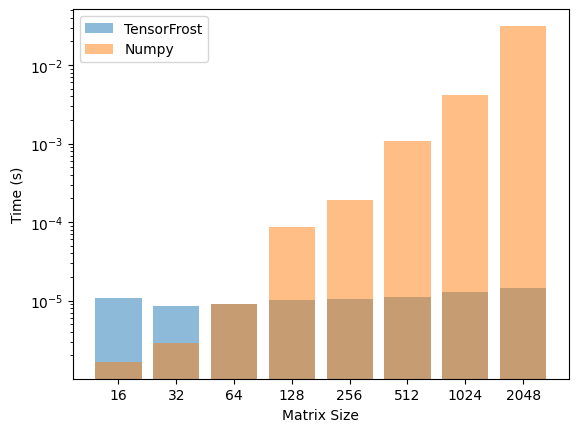

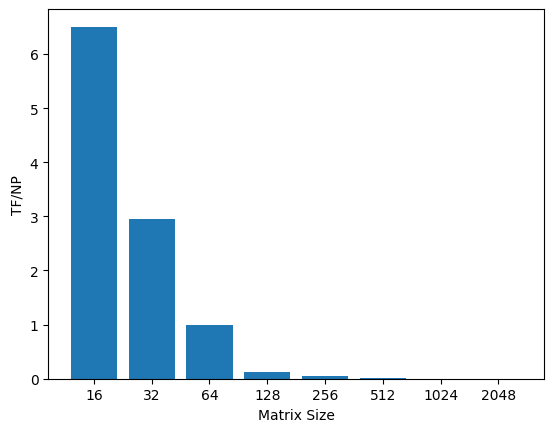

[1.073439626833844e-05, 8.564074341918992e-06, 9.15123052167227e-06, 1.0231121023930592e-05, 1.034294491512255e-05, 1.1195228859034192e-05, 1.267910124579355e-05, 1.4272664992007308e-05]
[1.6502008010862798e-06, 2.901215974005286e-06, 9.151712352977711e-06, 8.581134176393339e-05, 0.0001900102844180351, 0.0010711733227878873, 0.0041470232088703755, 0.031468749046325684]


In [6]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost", alpha=0.5)
plt.bar(size_str, np_times, label="Numpy", alpha=0.5)
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)